# Chartbusters Prediction : Foretell The Popularity Of Songs
<img src=https://www.machinehack.com/wp-content/uploads/2019/12/ChartbustersPrediction-scaled.jpg width="500" height="300"></img>

One of MachineHack's customers strongly believes in technology and has recently backed up its platform using Machine Learning and Artificial Intelligence. Based on data collected from multiple sources on different songs and various artist attributes their customer is excited to challenge the MachineHack community.

By analyzing the chartbusters data to predict the Views of songs, MachineHackers would advance the state of the current platform. This can help their customer understand user behaviour and personalize the user experience. In this hackathon, they challenge the MachineHackers to come up with a prediction algorithm that can predict the views for a given song.

Can you predict how popular a song will be in the future?

### Import Libaries and Helper Functions

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random
!pip install -q tqdm
from tqdm import tqdm

# Plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (12,8)


# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# Stats
from scipy.stats import skew, norm
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from math import sqrt

# Keras
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

pd.set_option('display.max_columns', None)

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

Using TensorFlow backend.


### Load and Explore Data

In [41]:
train = pd.read_csv('Data_Train.csv', index_col=None)
test = pd.read_csv('Data_Test.csv', index_col=None)
print('Train shape:',train.shape)
print('Test shape:',test.shape)

Train shape: (78458, 11)
Test shape: (19615, 10)


In [3]:
train.tail()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
78453,1144131,Resident Advisor,ambient,AU,RA.505 Josey Rebelle,2016-02-08 09:11:33.000000,12221,19,489,47,143726
78454,1415261,Trap Sounds,trap,AU,Drama We Cause - Lurtz [Exclusive],2016-03-02 01:24:39.000000,8265,4,292,100,211419
78455,705157,Mixmag,electronic,AU,Premiere: ELLLL 'SKITTLES',2019-02-11 13:15:05.000000,3621,1,157,31,1403057
78456,175337,DHA AM (Deep House London),electronic,AU,Night Vision - DHL Mix #124,2017-01-18 10:10:12.000000,8896,24,371,89,143743
78457,501778,Jon Z ✅,all-music,AU,Energy Freestyle,2015-04-11 22:32:05.000000,102487,4,"1,829",71,89084


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


**Note**: The target is the **Views** column. Since it is a continuous variable, this is a regression problem.

### Visualizing and Potentionally Transforming the Target


 mu = 546968.64 and sigma = 3883060.66



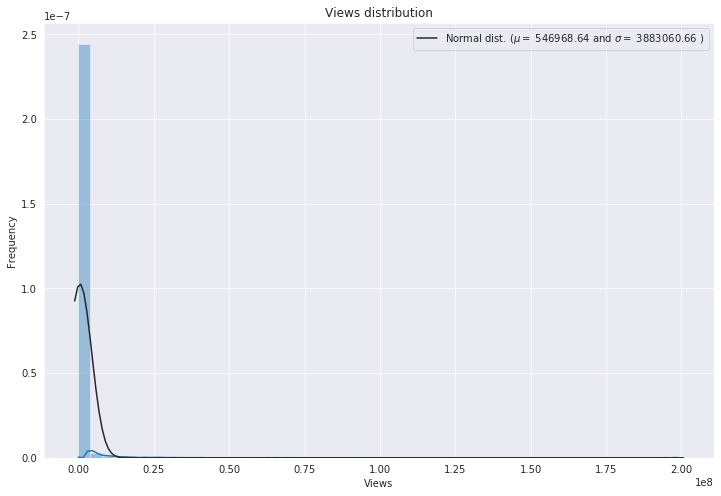

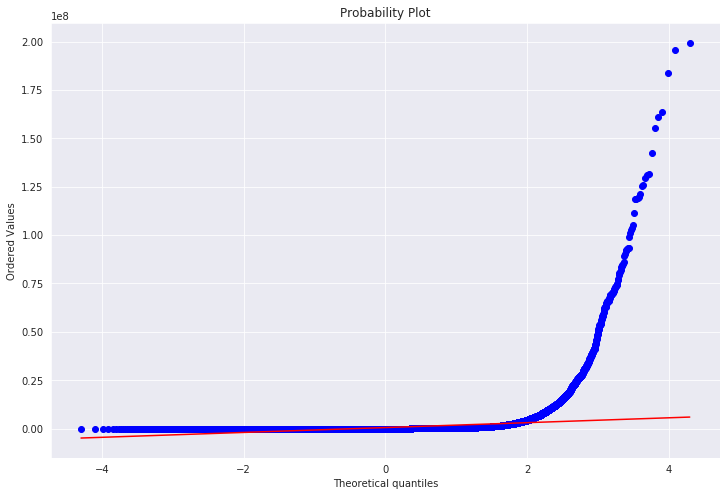

In [5]:
# Plot the Target distribution 
sns.distplot(train['Views'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Views'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Views distribution')

#Create a corresponding QQ-plot
fig = plt.figure()
res = stats.probplot(train['Views'], plot=plt)
plt.show()


 mu = 10.07 and sigma = 2.73



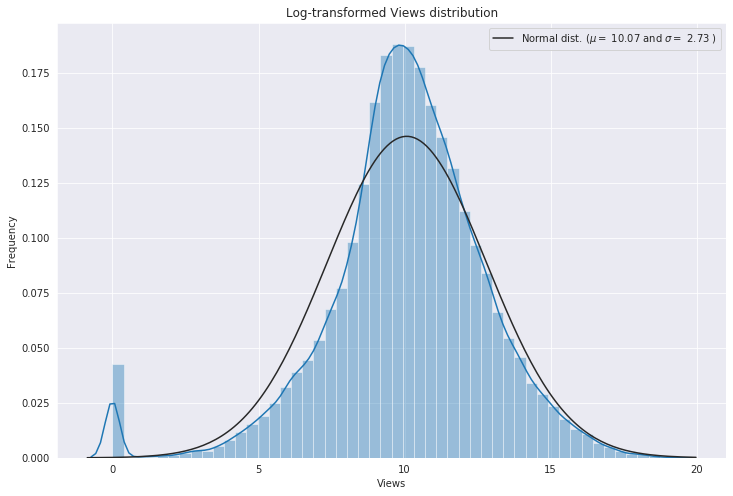

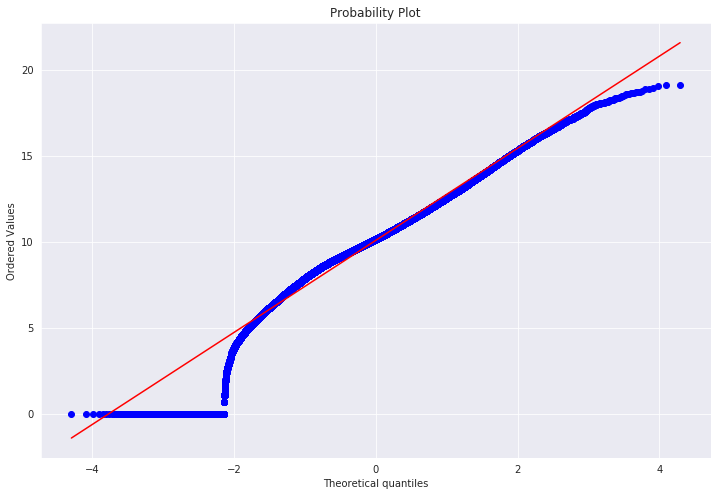

In [6]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# Plot the log-transformed distribution 
sns.distplot(np.log1p(train['Views']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(train['Views']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Log-transformed Views distribution')

# Create a corresponding QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(train['Views']), plot=plt)
plt.show()

**Important Note**: The distribution is extremely right-skewed. Ordinarily, we would need to linearlize the distribution using a suitable transformation so that the fitted regression model performs well (an assumption of inferential statistics). A popular choice is the [log transformation](http://onlinestatbook.com/2/transformations/log.html).

However, while running experiments, it was noted that fitted tree-based models performed *significantly* worse against the evaluation metric when the target was log-transformed. I'm curious as to why this is the case. One hypothesis, is that, while training, the model gives higher weights to non-predictive features when the target is transformed. It was empirically observed during experiments. Perhaps it is a peculiarity to do with this particular dataset.

To conclude, we will leave the target as-is.

### Combine the Datasets for Data Cleaning and Feature Analysis

In [0]:
# Drop the Target after storing the values for later
Y_train = train.Views.values
target = "Views"
train.drop([target], axis=1, inplace=True)

# Save the 'Unique_ID' column for later use
train_ID = train['Unique_ID']
test_ID = test['Unique_ID']

# Drop the 'Unique_ID column since it is unnecessary for the analysis and prediction phase.
train.drop("Unique_ID", axis = 1, inplace = True)
test.drop("Unique_ID", axis = 1, inplace = True)

# Combine the dataframes
alldata = pd.concat([train, test], axis=0, sort=False, ignore_index=True)

### Data Cleaning

**Note:** The Likes and Popularity columns substitute Ks and Ms for 1000s and 1000000s, respectively (e.g. 2500 is 2.5K). We need to find and convert those string representations into numeric values.

In [0]:
def clean_likes_popularity(data):
    data = data.apply(lambda x: x.replace(',',''))
    a = 'K'
    b = 'M'
    data = data.apply(lambda x: int(float(x.replace('K',''))*1000) if a in x else(int(float(x.replace('M',''))*1000000) if b in x else int(x)))
    
    return data

In [0]:
alldata['Likes'] = clean_likes_popularity(alldata['Likes'])
alldata['Popularity'] = clean_likes_popularity(alldata['Popularity'])

In [0]:
alldata['Timestamp'] = pd.DatetimeIndex(alldata['Timestamp'])
alldata['dayofweek'] = alldata['Timestamp'].dt.dayofweek
alldata['dayofyear'] = alldata['Timestamp'].dt.dayofyear
alldata['weekofyear'] = alldata['Timestamp'].dt.weekofyear
alldata['Year'] = alldata['Timestamp'].dt.year
alldata['Month'] = alldata['Timestamp'].dt.month
alldata['Day'] = alldata['Timestamp'].dt.day
alldata['Hour'] = alldata['Timestamp'].dt.hour
alldata['Minute'] = alldata['Timestamp'].dt.minute
alldata['Second'] = alldata['Timestamp'].dt.second

In [0]:
# Mean-imputation of missing values
alldata['Followers'] = pd.to_numeric(alldata['Followers'], errors='coerce')
alldata['Likes'] = pd.to_numeric(alldata['Likes'], errors='coerce').fillna(pd.to_numeric(alldata['Likes'], errors='coerce').mean())
alldata['Popularity'] = pd.to_numeric(alldata['Popularity'], errors='coerce').fillna(pd.to_numeric(alldata['Popularity'], errors='coerce').mean())

### Feature Analysis and Feature Engineering

In [12]:
alldata.Song_Name.nunique(), alldata.shape[0]

(98072, 98073)

**Note:** The song names seem to be unique and may need to be dropped. We could later extract some TF-IDF & CountVectorizer vectors (or even GloVe embeddings if we're ambitious) from it. For now, we will instead choose create a new feature for the number of collaborating/featured artists on a song. This can be identified in the data with either 'FEAT', 'feat', or 'Feat'.

In [0]:
# Drop Song_Name
alldata['Collaborators'] = alldata['Song_Name'].str.count('FEAT|feat|Feat')
alldata.drop(columns=['Song_Name'], axis=1, inplace=True)

In [14]:
# Clean up text using regex
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

alldata['Name'] = alldata['Name'].astype(str)
alldata['Name'] = alldata['Name'].apply(clean_text)
alldata['Name'] = alldata['Name'].astype('O')
alldata.head()

,Name,Genre,Country,Timestamp,Comments,Likes,Popularity,Followers,dayofweek,dayofyear,weekofyear,Year,Month,Day,Hour,Minute,Second,Collaborators
0,hardstyle,danceedm,AU,2018-03-30 15:24:45,4,499,97,119563,4,89,13,2018,3,30,15,24,45,0.00000
1,aladdin,danceedm,AU,2016-06-20 05:58:52,17,49,17,2141,0,172,25,2016,6,20,5,58,52,0.00000
2,maxximize air,danceedm,AU,2015-05-08 17:45:59,11,312,91,22248,4,128,19,2015,5,8,17,45,59,0.00000
3,explode,rbsoul,AU,2017-06-08 23:50:03,2,2400,76,393655,3,159,23,2017,6,8,23,50,3,0.00000
4,tritonal,danceedm,AU,2016-09-17 20:50:19,81,3031,699,201030,5,261,37,2016,9,17,20,50,19,1.00000


In [0]:
# Create interaction features. Note: They be correlated with many columns in our dataframe

# Start with Likes in the numerator
alldata['Likes_Followers'] = np.divide(alldata['Likes'], alldata['Followers'])
alldata['Likes_Popularity'] = np.divide(alldata['Likes'], alldata['Popularity'])
alldata['Likes_Comments'] = np.divide(alldata['Likes'], alldata['Comments'])

# Followers
alldata['Followers_Popularity'] = np.divide(alldata['Followers'], alldata['Popularity'])
alldata['Followers_Comments'] = np.divide(alldata['Followers'], alldata['Comments'])
alldata['Followers_Likes'] = np.divide(alldata['Followers'], alldata['Likes'])

# Popularity
alldata['Popularity_Followers'] = np.divide(alldata['Popularity'], alldata['Followers'])
alldata['Popularity_Comments'] = np.divide(alldata['Popularity'], alldata['Comments'])
alldata['Popularity_Likes'] = np.divide(alldata['Popularity'], alldata['Likes'])

alldata['Total_Metrics'] = alldata['Likes'] + alldata['Popularity'] + alldata['Followers'] + alldata['Comments']

#### Aggregate Descriptive Stats of Features

**Note:** This feature engineering step is inspired by the [winning solution](https://github.com/chetanambi/Predicting-Food-Delivery-Time-Hackathon-by-IMS-Proschool/blob/master/predicting-food-delivery-time-catboost_0.83958.ipynb) of MachineHack: [Predict Food Delivery Time](https://www.machinehack.com/course/predicting-food-delivery-time-hackathon-by-ims-proschool/) by Chetan Ambi. Any aspiring competitive data science enthusiast will find winning solutions to previous hackathons an invaluable learning resource. I highly recommend it!

In [0]:
agg_func = {
    'Likes': ['sum'],
    'Followers': ['sum'],
    'Popularity': ['sum'],
    'Comments': ['sum']
}
agg_Year_Name = alldata.groupby(['Year','Name']).agg(agg_func)
agg_Year_Name.columns = [ 'Year_Name_' + ('_'.join(col).strip()) for col in agg_Year_Name.columns.values]
agg_Year_Name.reset_index(inplace=True)
alldata = alldata.merge(agg_Year_Name, on=['Year','Name'], how='left')
del agg_Year_Name

In [0]:
agg_func = {
    'Likes': ['mean', 'median','sum','min','max'],
    'Followers': ['mean', 'median','sum','min','max'],
    'Popularity': ['mean', 'median','sum','min','max'],
    'Comments': ['mean', 'median','sum','min','max']
}
agg_Name = alldata.groupby('Name').agg(agg_func)
agg_Name.columns = [ 'Name' + ('_'.join(col).strip()) for col in agg_Name.columns.values]
agg_Name.reset_index(inplace=True)
alldata = alldata.merge(agg_Name, on=['Name'], how='left')
del agg_Name

### Encoding Categorical Features

In [0]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

In [0]:
ntrain = train_ID.shape[0]
train_df = alldata[:ntrain]
test_df = alldata[ntrain:]
train_df['Views'] = Y_train

In [0]:
# Obtaining mean-encoded features
# It was observed that performance suffers with target-encoded features. Future work should try regularization
'''cat_vars = ['Genre','Year', 'Month', 'Day','Name','Hour','Minute','Second']
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'Views')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'Views')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

train_df.drop(["Views"], axis=1, inplace=True)
alldata = pd.concat([train_df, test_df], axis=0, sort=False, ignore_index=True)'''

In [21]:
# Find non-numeric columns
alldata.dtypes[alldata.dtypes == "object"].index

Index(['Name', 'Genre', 'Country'], dtype='object')

In [22]:
print('Unique countries:', alldata['Country'].nunique())
print('Unique genres:', alldata['Genre'].nunique())
print('Unique names:', alldata['Name'].nunique())

Unique countries: 1
Unique genres: 21
Unique names: 1160


**Note:** We will drop *Country* and dummy-encode *Genre*. We will label-encode *Name* instead of dummy-encoding to avoid the curse of dimensionality and the resulting induced data sparseness; not because there exists an inherent ordering in *Name*.

In [23]:
# Create dummy/one-hot encodings. Note: The only difference being that dummies convert n values of a categorical to n-1 variables,
# whereas one-hot encodings create n variables
alldata = pd.get_dummies(alldata, columns=['Genre'], drop_first=True)

lbl = LabelEncoder()
alldata['Name'] = lbl.fit_transform(alldata['Name'])

alldata.drop(['Country','Timestamp'], axis=1, inplace=True)
alldata.head()

,Name,Comments,Likes,Popularity,Followers,dayofweek,dayofyear,weekofyear,Year,Month,Day,Hour,Minute,Second,Collaborators,Likes_Followers,Likes_Popularity,Likes_Comments,Followers_Popularity,Followers_Comments,Followers_Likes,Popularity_Followers,Popularity_Comments,Popularity_Likes,Total_Metrics,Year_Name_Likes_sum,Year_Name_Followers_sum,Year_Name_Popularity_sum,Year_Name_Comments_sum,NameLikes_mean,NameLikes_median,NameLikes_sum,NameLikes_min,NameLikes_max,NameFollowers_mean,NameFollowers_median,NameFollowers_sum,NameFollowers_min,NameFollowers_max,NamePopularity_mean,NamePopularity_median,NamePopularity_sum,NamePopularity_min,NamePopularity_max,NameComments_mean,NameComments_median,NameComments_sum,NameComments_min,NameComments_max,mean_enc_Genre,mean_enc_Year,mean_enc_Month,mean_enc_Day,mean_enc_Name,mean_enc_Hour,mean_enc_Minute,mean_enc_Second,Genre_alternativerock,Genre_ambient,Genre_classical,Genre_country,Genre_danceedm,Genre_deephouse,Genre_disco,Genre_drumbass,Genre_dubstep,Genre_electronic,Genre_folksingersongwriter,Genre_hiphoprap,Genre_indie,Genre_latin,Genre_metal,Genre_pop,Genre_rbsoul,Genre_reggaeton,Genre_rock,Genre_trap
0,395,4,499,97,119563,4,89,13,2018,3,30,15,24,45,0.00000,0.00417,5.14433,124.75000,1232.60825,29890.75000,239.60521,0.00081,24.25000,0.19439,120163,139243,28455994,20566,1586,768.75879,521.00000,1093175,47,25400,119563.00000,119563.00000,170018586,119563,119563,134.36146,101.00000,191062,4,2207,8.73840,6.00000,12426,0,158,265181.27478,344930.95509,821604.15775,589832.44105,29456.96788,327456.41285,486722.41135,648468.47262,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21,17,49,17,2141,0,172,25,2016,6,20,5,58,52,0.00000,0.02289,2.88235,2.88235,125.94118,125.94118,43.69388,0.00794,1.00000,0.34694,2224,7929,17128,787,220,486.86667,183.00000,14606,37,5479,2141.00000,2141.00000,64230,2141,2141,59.43333,33.00000,1783,11,215,13.23333,7.50000,397,1,56,265181.27478,736096.73028,627699.01313,423931.60229,27033.58791,1376434.75381,510749.92840,298022.57546,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,653,11,312,91,22248,4,128,19,2015,5,8,17,45,59,0.00000,0.01402,3.42857,28.36364,244.48352,2022.54545,71.30769,0.00409,8.27273,0.29167,22662,14258,1112400,4188,719,445.46114,282.00000,85974,59,3467,22248.00000,22248.00000,4293864,22248,22248,129.01554,76.00000,24900,11,1125,20.69948,12.00000,3995,0,179,265181.27478,868298.79185,547888.02419,523470.54702,19588.32840,402834.28143,561156.91817,613892.87075,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,304,2,2400,76,393655,3,159,23,2017,6,8,23,50,3,0.00000,0.00610,31.57895,1200.00000,5179.67105,196827.50000,164.02292,0.00019,38.00000,0.03167,396133,4234279,233437415,105357,4364,4090.31483,919.00000,7145780,0,159000,393655.00000,393655.00000,687715285,393655,393655,96.61477,34.00000,168786,0,4133,4.18546,1.00000,7312,0,181,604235.43387,603845.28618,627699.01313,523470.54702,220774.83549,747189.79867,491572.36378,484799.93283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1051,81,3031,699,201030,5,261,37,2016,9,17,20,50,19,1.00000,0.01508,4.33619,37.41975,287.59657,2481.85185,66.32465,0.00348,8.62963,0.23062,204841,109640,5628840,23464,2759,2314.54678,974.50000,791575,0,64700,201030.00000,201030.00000,68752260,201030,201030,565.90936,244.00000,193541,0,15000,58.87719,33.50000,20136,0,1296,265181.27478,736096.73028,490372.93580,649635.43884,113185.64737,526598.82549,491572.36378,556654.62294,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Be mindful of null and inf values and convert them to the np.nan type
# Maybe Pandas 1.0 will make life easier. See https://analyticsindiamag.com/whats-new-in-pandas-1-0/
np.any(alldata.isnull())

True

In [25]:
# Not going to use numpy.nan_to_num since infinity is replaced by very large finite values, potentially biasing our models
alldata = alldata.replace([np.inf, -np.inf], np.nan)
alldata = alldata.fillna(0)
np.any(alldata.isna())

False

In [0]:
# Worse performance is observed after performing these transformations. Hence, omitted.
'''from sklearn.preprocessing import StandardScaler, RobustScaler

numeric_feats = alldata.dtypes[alldata.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = alldata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
for feat in skewed_features:
    alldata[feat] = np.log1p(alldata[feat])

sc = StandardScaler()
alldata[numeric_feats] = sc.fit_transform(np.nan_to_num(alldata[numeric_feats]))'''

### Creating Train/Dev Splits

In [0]:
ntrain = train_ID.shape[0] # We saved the 'Unique_ID' column at the beginning
train = alldata[:ntrain]
test = alldata[ntrain:]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(train, Y_train, test_size=0.25, random_state=0)
X_train.shape, X_dev.shape, y_train.shape, y_dev.shape

((58843, 77), (19615, 77), (58843,), (19615,))

### Tree-Based Regression Models

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import lightgbm as lgb

In [0]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### LGBM

In [30]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2_root',
    'max_depth': -1,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'verbose': 0,
    'n_jobs': -1,
    }
n_estimators = 4000

n_iters = 5
preds_buf = []
err_buf = []
evals_result = {}
for i in range(n_iters): 
    x_train, x_valid, y_train, y_valid = train_test_split(train, Y_train, test_size=0.25, random_state=i)
    d_train = lgb.Dataset(x_train, label=y_train)
    d_valid = lgb.Dataset(x_valid, label=y_valid)
    watchlist = [d_valid]
    
    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1000, early_stopping_rounds=200, evals_result=evals_result)
    preds = model.predict(x_valid, num_iteration=model.best_iteration)
    err = sqrt(mean_squared_error(y_valid, preds))
    err_buf.append(err)
    print('RMSLE = ' + str(err))


print('Mean RMSLE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[178]	valid_0's rmse: 620300
RMSLE = 620300.2196834154
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 906019
Early stopping, best iteration is:
[1269]	valid_0's rmse: 905552
RMSLE = 905552.0867835734
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 565667
Early stopping, best iteration is:
[1189]	valid_0's rmse: 565082
RMSLE = 565081.7332982763
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[543]	valid_0's rmse: 958234
RMSLE = 958234.1119800737
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[48]	valid_0's rmse: 941817
RMSLE = 941817.0260835942
Mean RMSLE = 798197.0355657866 +/- 169560.42921501474


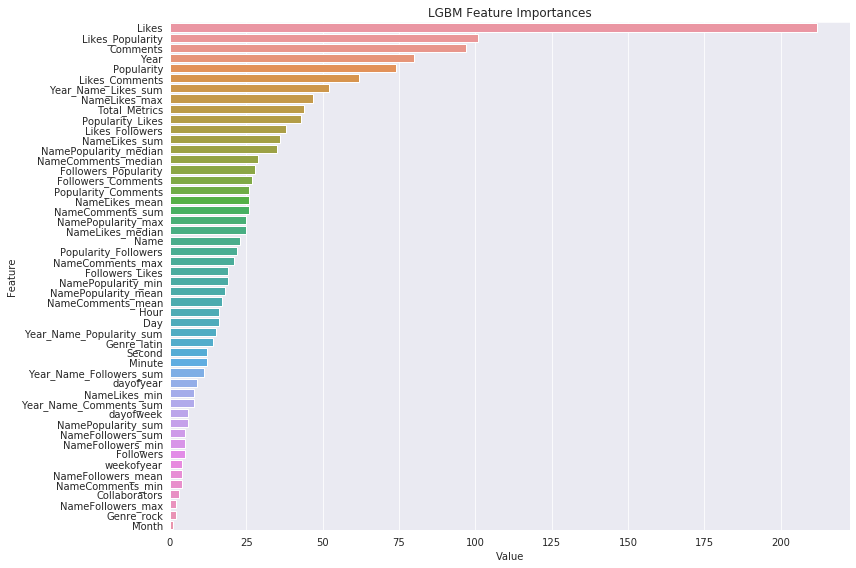

In [31]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), alldata.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBM Feature Importances')
plt.tight_layout()
plt.show()

#### XGBoost

In [35]:
model_xgb = xgb.XGBRegressor(learning_rate=0.1,
                          n_estimators=4000,
                          verbosity=3,
                          objective='reg:squarederror',
                          n_jobs=-1,
                          subsample=0.8,
                          random_state=0,
                          tree_method='gpu_hist')
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_dev)
print('RMSE', sqrt(mean_squared_error(y_dev, y_pred_xgb)))

RMSE 3571726.820830554


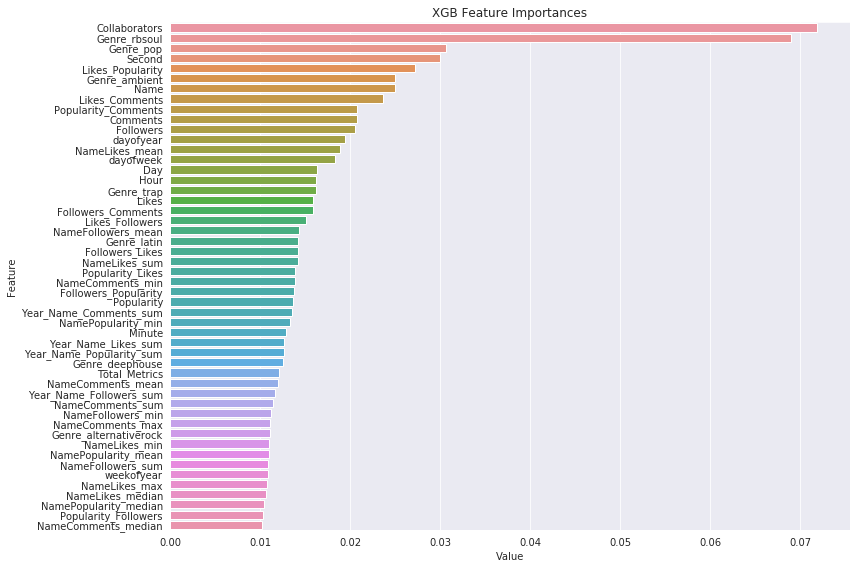

In [36]:
feature_imp = pd.DataFrame(sorted(zip(model_xgb.feature_importances_, alldata.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Feature Importances')
plt.tight_layout()
plt.show()

In [0]:
del model_xgb
model_xgb = xgb.XGBRegressor(learning_rate=0.1,
                          n_estimators=4000,
                          verbosity=3,
                          objective='reg:squarederror',
                          n_jobs=-1,
                          subsample=0.95,
                          random_state=0,
                          tree_method='gpu_hist')
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#Xgboost score: 785013.5222 (119072.6154)

#### GradientBoostingRegressor

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor(learning_rate=0.2,
                               n_estimators=1500,
                               subsample=0.8,
                               random_state=0,
                               verbose=1)
model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_dev)
print('RMSE', sqrt(mean_squared_error(y_dev, y_pred)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 10853365845117.2188 4959463295419.4355           12.11m
         2 7468982465170.4502 3036599422792.6533           11.89m
         3 5103010224344.0000 2084271094793.9810           11.84m
         4 3399309109491.2583 1304942024811.2061           11.82m
         5 2396955522520.6182 999831289959.0818           11.76m
         6 1607873427214.1733 603445188821.9910           11.77m
         7 1220808244648.7961 385815696622.3005           11.78m
         8 892577762705.4023 289064471080.4836           11.79m
         9 706552896591.7443 185151497574.1179           11.77m
        10 528872307751.0637 152649190266.1892           11.80m
        20 221429146860.8983  1042618105.1793           11.74m
        30 165427154614.4551  -587760884.8721           11.68m
        40 146260319414.6407   -34016149.6725           11.58m
        50 121059270209.7304  -422667912.3304           11.49m
        60 105964158482.9812  -96

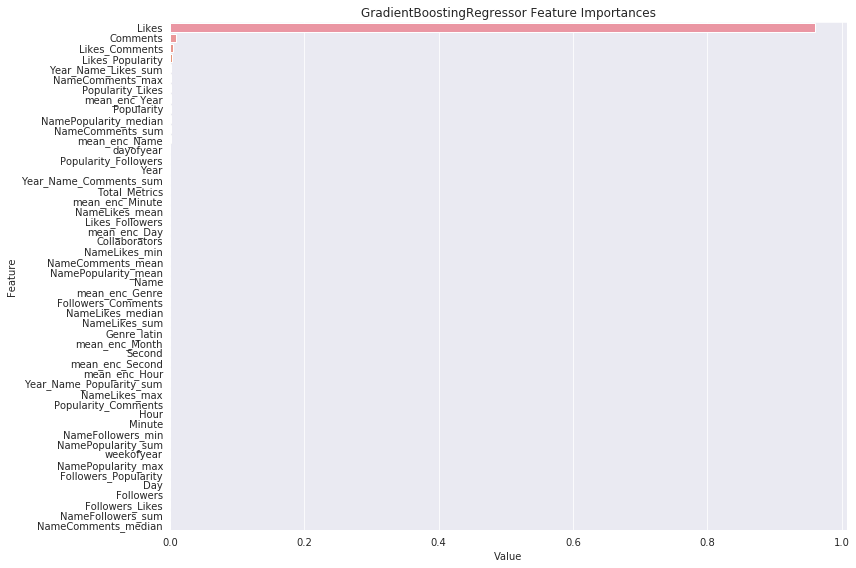

In [31]:
feature_imp = pd.DataFrame(sorted(zip(model_gb.feature_importances_, X_train.columns), reverse=True)[:50], columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('GradientBoostingRegressor Feature Importances')
plt.tight_layout()
plt.show()

**Note:** GradientBoostingRegressor shows the most promise, so we will use multiple versions of this model and ensemble them to create the final predictions.

In [0]:
# Note: will take a long time to run. Time will vary depending on your machine
rmse = []
preds = []
fold = KFold(n_splits=10, shuffle=False, random_state=0)

for train_idx, test_idx in fold.split(train):
    X_train, X_dev = train.loc[train_idx], train.loc[test_idx]
    y_train, y_dev = Y_train[train_idx], Y_train[test_idx]

    model_gb = GradientBoostingRegressor(learning_rate=0.2,
                                   subsample=0.8,
                                   n_estimators=1500,
                                   random_state=0)
    model_gb.fit(X_train, y_train)
    y_pred = model_gb.predict(X_dev)
    print('RMSE', sqrt(mean_squared_error(y_dev, y_pred)))
    rmse.append(sqrt(mean_squared_error(y_dev, y_pred)))

    predictions = model_gb.predict(test)
    preds.append(predictions)

In [0]:
print('Mean RMSLE = ', np.mean(rmse))

In [0]:
preds_iter_1 = np.mean(preds)

**Note:** iterate through the folds and store the resultant predictions alongside the Unique IDs. The final ensemble was a hand-picked, normally weighted, additive combination of folds.

-------------------------------------------------------------------------------

This marks the end of the notebook for the hackathon! The below ideas are experimental, and therefore not used in the hackathon. However, MachineHack's customer for this hackathon may find some value in it.

I have a strong feeling that the customer is [SoundCloud](https://soundcloud.com/pages/contact) due to the one-to-one correspondence of song titles in the data and the songs on the website. That said, the duration of songs could plausibly be a strong predictor of the number of views. Anecdotal evidence and published research on the subject supports this hypothesis.

Of course, if the customer is SoundCloud, they have direct access to this data. Nevertheless, the code below demonstrates a proof-of-concept (PoC) of obtaining this data using the [SoundCloud API](https://developers.soundcloud.com/docs/api/guide). Bare in mind that doing so may violate SoundCloud's ToS and there is therefore not condoned by the author. It only serves as a benign PoC.

In [0]:
!pip install -q soundcloud
song_titles = alldata.Song_Name.values

In [0]:
import soundcloud

# create a client object with your app credentials or alternatively inspect GET requests to the website from you browser for this parameter
client = soundcloud.Client(client_id='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

durations = []
for i in range(0, len(song_titles)):
  try:
    tracks = client.get('/tracks', q=song_titles[i])
    if len(tracks) == 0:
      durations.append('None')
    else:
      durations.append(tracks[0].duration)
      if i % 1000 == 0:
        print('[*]Downloaded durations: ', i)
  except (Exception):
    try:
      tracks = client.get('/tracks', q=song_titles[i])
      if len(tracks) == 0:
        durations.append('None')
      else:
        durations.append(tracks[0].duration)
        pass
    except (Exception):
      durations.append('None')
      pass
print('[✓]Download Complete...')

In [0]:
song_length = pd.DataFrame(durations, columns=["duration"])
# The customer can combine the song durations feature along with the original dataset and observe model performance.